## Play-ground to make initial data distributions.

In [12]:
import Pkg; Pkg.add("FileIO")
using Distributions
using Plots
using FileIO
using JLD2
Pkg.instantiate()

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [31c24e10] + Distributions v0.25.49
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [5789e2e9] + FileIO v1.13.0
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


### This is a Maxwellinan distribution (3D) centered around v=0 and with m/kT = 1

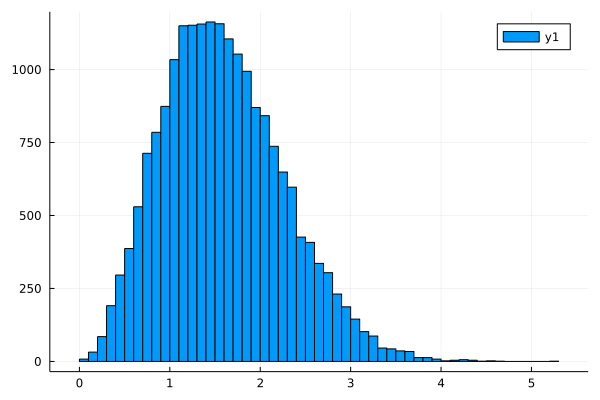

In [3]:
d  = LocationScale(0.0,1.,Chi(3))
data = rand(d,20000);
histogram(data)

The 1D distribution for $\frac{m}{kT} = 1$ is just the normal distribution centered at both $\pm v_p$. With $\sigma = 1$.


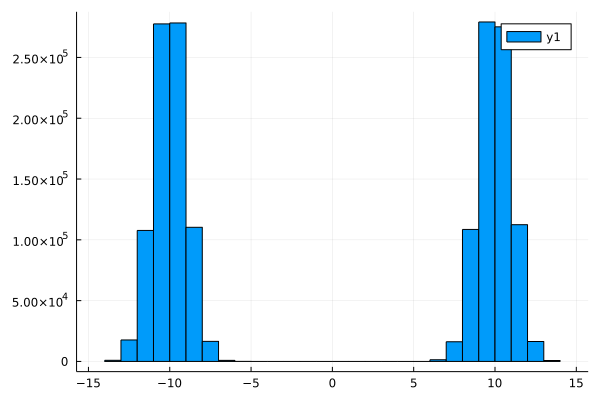

In [4]:
N = 40000
vb = -10

data_n = [rand(Normal(-vb,1),N÷2); rand(Normal(vb,1),N÷2)]  #.+ rand(Normal(-1,1),20000)
histogram(data_n, bins=:scott, weights=repeat(1:80, outer=500))

### This is the distribution on the course, just to check that it is the same... 

I should apply some statistics here and check different momenta :-)

In [5]:
"""The following routine returns a random velocity distributed on a double Maxwellian distribution function corresponding to two counter-streaming beams. The algorithm used to achieve this is called the rejection method, and will be discussed later in this course.

  // Function to distribute electron velocities randomly so as 
  // to generate two counter propagating warm beams of thermal
  // velocities unity and mean velocities +/- vb.
  // Uses rejection method.
"""
function distribution_stream(vb)
  #Generate random v value
  fmax = 0.5 * (1. + exp(-2.0 * vb * vb));
  vmin = - 5.0 * vb;
  vmax = + 5.0 * vb;
  v = vmin + (vmax - vmin) * (rand());

  #  Accept/reject value
  f = 0.5 * (exp(-(v - vb) * (v - vb) / 2.0) + exp(-(v + vb) * (v + vb) / 2.0))
  x = fmax * rand()
  if (x > f) return distribution_stream(vb)
  else return v
  end
end

distribution

In [6]:
v = zeros(N)
for i in 1:N
    v[i] = distribution(vb)
end

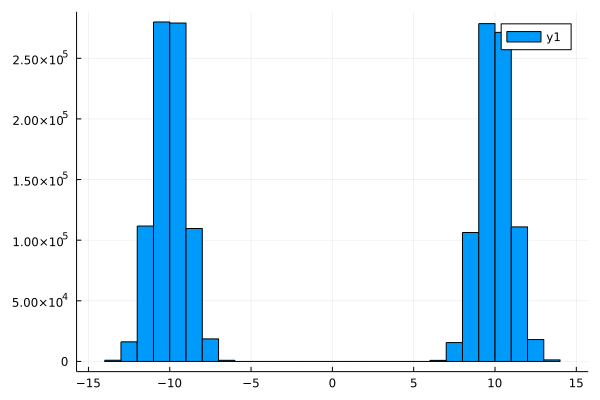

In [7]:
histogram(v, bins=:scott, weights=repeat(1:80, outer=500))

At first sigth they look very similar....

We now make and save some distributions to use as standard ones.

In [10]:
L = 100 #length of integration region
#N = 200000
N = 80000 #even number
vb = 3

r = L*rand(N);
vp = rand(Normal(vb,1),N÷2);
u = [r; -vp; vp];

#save("Initial_Distributions/par_dis_L100_N8_5_vp_3.jld2", "par_dis", u)

## Thermal Distributions

$$
f(x,v) = \frac{N}{L} \frac{1}{\sqrt{2\pi \theta}} e^{-\frac{v^2}{2\theta}}
$$

Thus, $\theta = \sigma^2$ is the variance of the distribution.

In [2]:
L = 5 #length of integration region
#N = 200000
N = 80000 #even number
θ = 0.01

r = L*rand(N);
vp = rand(Normal(0,sqrt(θ)),N);
u = [r; vp];

In [3]:
mean(vp)
var(vp)

0.00997843983532115

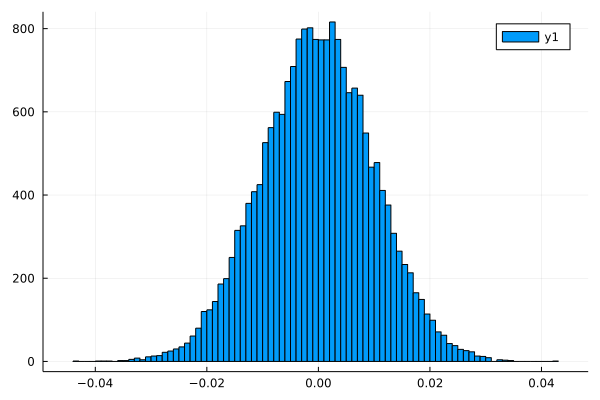

In [24]:
histogram(vp)

In [4]:
save("Initial_Distributions/par_dis_L5_N8_5_theta01.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_L5_N2_5_theta001.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_L5_N2_5_theta0001.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_L5_N2_5_theta00001.jld2", "par_dis", u)


## Landau Damping ##

The initial distribution is: 

$$
f(x,v,\alpha, k, \theta) = \frac{1}{\sqrt{2\pi \theta}} e^{-\frac{v^2}{2\theta}} (1 + \alpha cos(kx) )
$$

Since it is a product we can split into two distributions one for the position and one for the velocity.
The one for the velocity we already have, so we need to make only the random sampling of the spatial one. 

Some definitions $\hat{k} = k / k_D = k * \sqrt{\theta}$ Or $k = \hat{k} / \sqrt{\theta}$ 

In these simulations, $\theta = 10^{-3}$ $\sqrt{\theta} = 0.03162$

Thus to $\hat{k} = 0.01$ corresponds a $\lambda = 2\pi * \sqrt{\theta} / \hat{k} = 19.869$

For $\hat{k} = 0.40$ corresponds a $\lambda = 0.497$

For the first case an $L = 2 \lambda = 39.738$ is used and $J = 1761*2 = 3522$, $dx = L/J = 0.0112$

For the second $L=15*\lambda = 7.455$ is used and $J = 62 * 15 = 930$, $dx = 0.0080$

In [61]:
7.455 / (62 * 15)


0.008016129032258065

In [21]:
"""The following routine returns a random random according to a given distribution function.
 The algorithm used to achieve this is called the rejection method.
 f is the distribution function and p are its parameters. We need also
 f_max which is a function of p, and the interval of the sampling region
 int = (x_min,x_max)
"""
function random_sampling_from_distribution(f,f_max,p,int)
  (x_max,x_min) = int
  fmax = f_max(p)
  x = x_min + (x_max - x_min) * (rand());
  #  Accept/reject value
  f_v = f(x,p)
  x_t = fmax * rand()
  if (x_t > f_v) return random_sampling_from_distribution(f,f_max,p,int)
  else return x
  end
end

random_sampling_from_distribution

In [66]:
N = 80_000
#L= 39.738 
L = 7.455

m = 15 # 2, 12, 15, 19
k = 2π*m/L # this here is k, not \hat{k}
α = 0.01 # 0.01
θ = 0.001 # 0.001
p = (α, k)

function f(x,p) 
    α, k = p
    return 1 + α *cos(k*x)
end

function f_max(p)
    α, k = p
    return 1+α
end

int = (0., L)
r = zeros(N)
for i in 1:N
    r[i] = random_sampling_from_distribution(f,f_max,p,int)
end

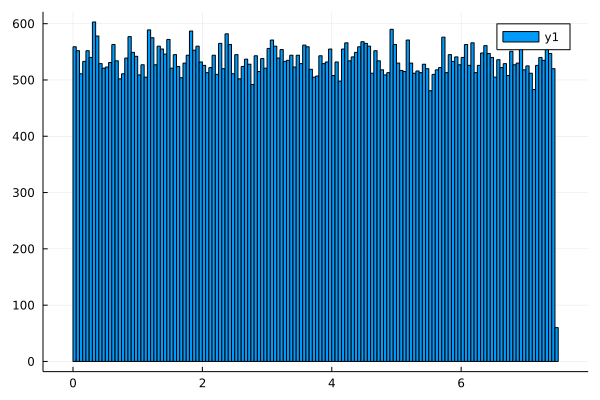

In [67]:
using GR
histogram(r
#, bins=:scott
, bins=200
#, weights=repeat(1:80, outer=1000)
)

In [68]:
vp = rand(Normal(0,sqrt(θ)),N);
u = [r; vp];

In [69]:
#save("Initial_Distributions/par_dis_L40_N8_5_theta001_m1_am2.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_L40_N8_5_theta001_m2_am2.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_L40_N8_5_theta001_m4_am1.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_L40_N8_5_theta001_m4_am2.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_nodupming.jld2", "par_dis", u)
#save("Initial_Distributions/par_dis_dupming.jld2", "par_dis", u)